In [1]:
from grading_tools import check, auto_marking_message
import cvxopt
import numpy as np
from math import *
import matplotlib.pyplot as plt

# Exercises

## Exercise

If you invest $\$2500$ in Google stock and it grows to have a value of $\$3500$, what is your return?  

In [2]:
### BEGIN SOLUTION
(3500-2500)/2500
### END SOLUTION 

0.4

In [3]:
check('56c4ed',_)
auto_marking_message()

Auto marking message: ✔ Correct


## Exercise

Plot a chart of the historic weekly return of the first stock in the `ukx.xlsx` file. It should be very spiky and look a lot a graph of white noise.

How would you generate a sequence of normally distributed random numbers with the same mean and standard deviation as the returns of this first stock? Generate a plot of such random numbers that can be compared with the plot of historic weekly returns.

Can you visually detect any differences between the plots?

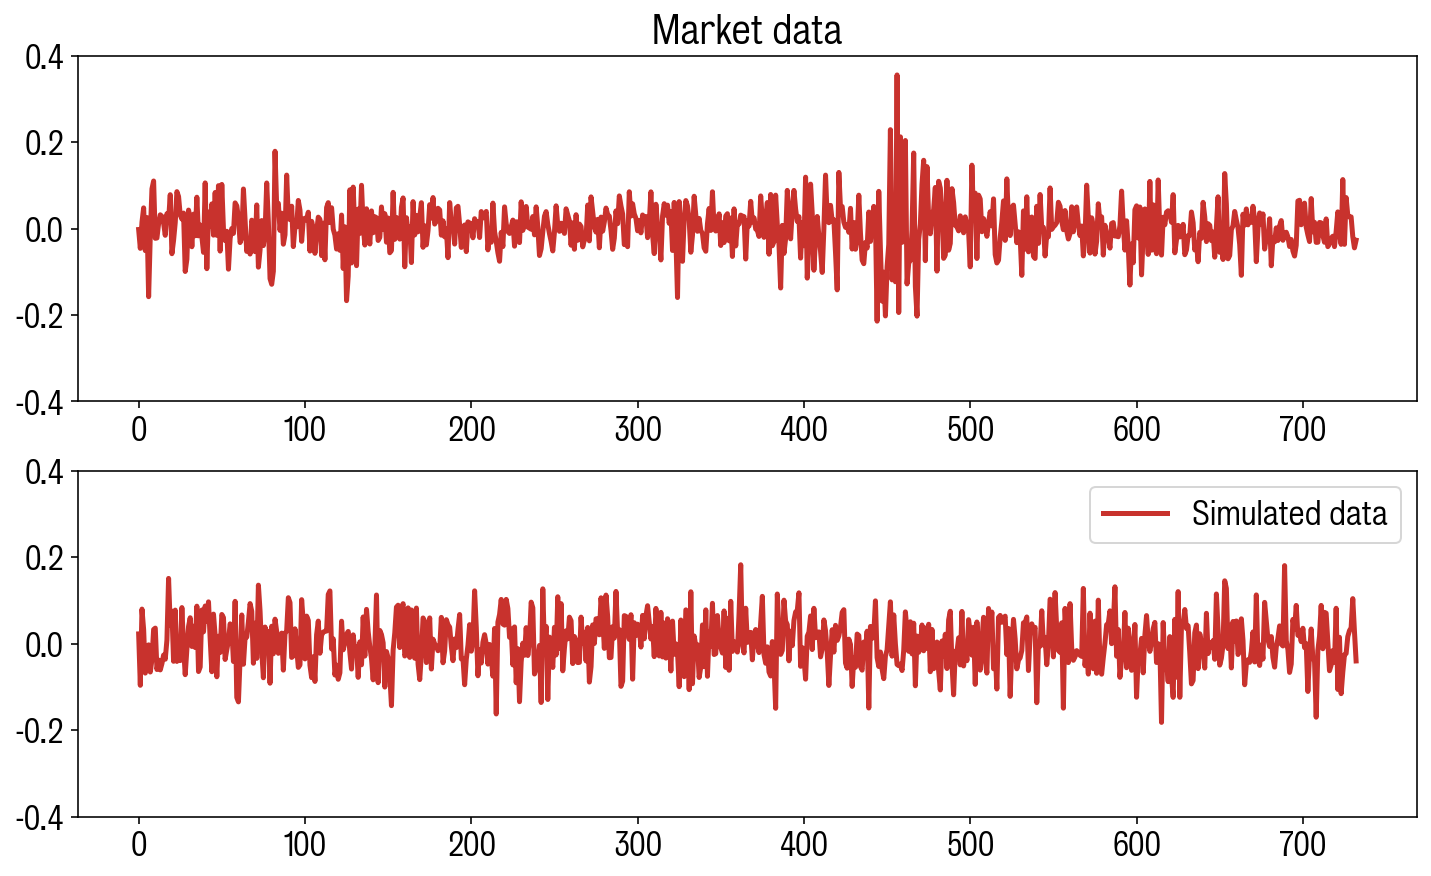

In [4]:
### BEGIN SOLUTION

# So you don't have to keep retyping the same
# code, I've created two handy functions read_return_history and solve_markowitz
# in the file markowitzlib.py which you can use. I expected you to just copy
# and paste the code from the handouts as I haven't yet shown you how to create
# your own libraries.
from markowitzlib import read_return_history

return_history = read_return_history()
stock1_history = return_history[:,0]

mean = np.mean( stock1_history )
sd = np.std( stock1_history )

fig,[ax1,ax2]=plt.subplots(2,1)

weeks = np.arange(0,len( stock1_history) )
ax1.plot(weeks, stock1_history, label='Market data' );
ax1.set_ylim(-0.4,0.4);
ax1.set_title('Market data')

simulated = np.random.randn( len(weeks))*sd + mean
ax2.plot(weeks, simulated, label='Simulated data' );
ax2.set_ylim(-0.4,0.4);
ax2.legend();
### END SOLUTION

## Exercise

The file `goog-options.xlsx` contains data for option prices on Google stock taken on one particular day.

Each row in the main table represents the price of a different call option. The first column contains an identifier for the specific call option contract. The word *security* is used to refer to a general financial product whether it is a stock, bond, option (or any other kind of financial product, so this identifier is called a *security identifier*.

The second column contains the *mid price* of the option.
There are two main prices quoted for any financial product on the market. The ask price is how much you must pay to buy a product, the bid price is how much you will receive if you sell the product. The mid price is the average of the two.

The third column is the last price traded.

The final column contains the strike price of each option. We have already seen a question describing what is meant by a call option, so you should be able to explain what the strike price means yourself.

Plot a graph of the mid price against the strike price.

So I can test your code, store the sum of all the mid prices in a variable called `sum_mids`.

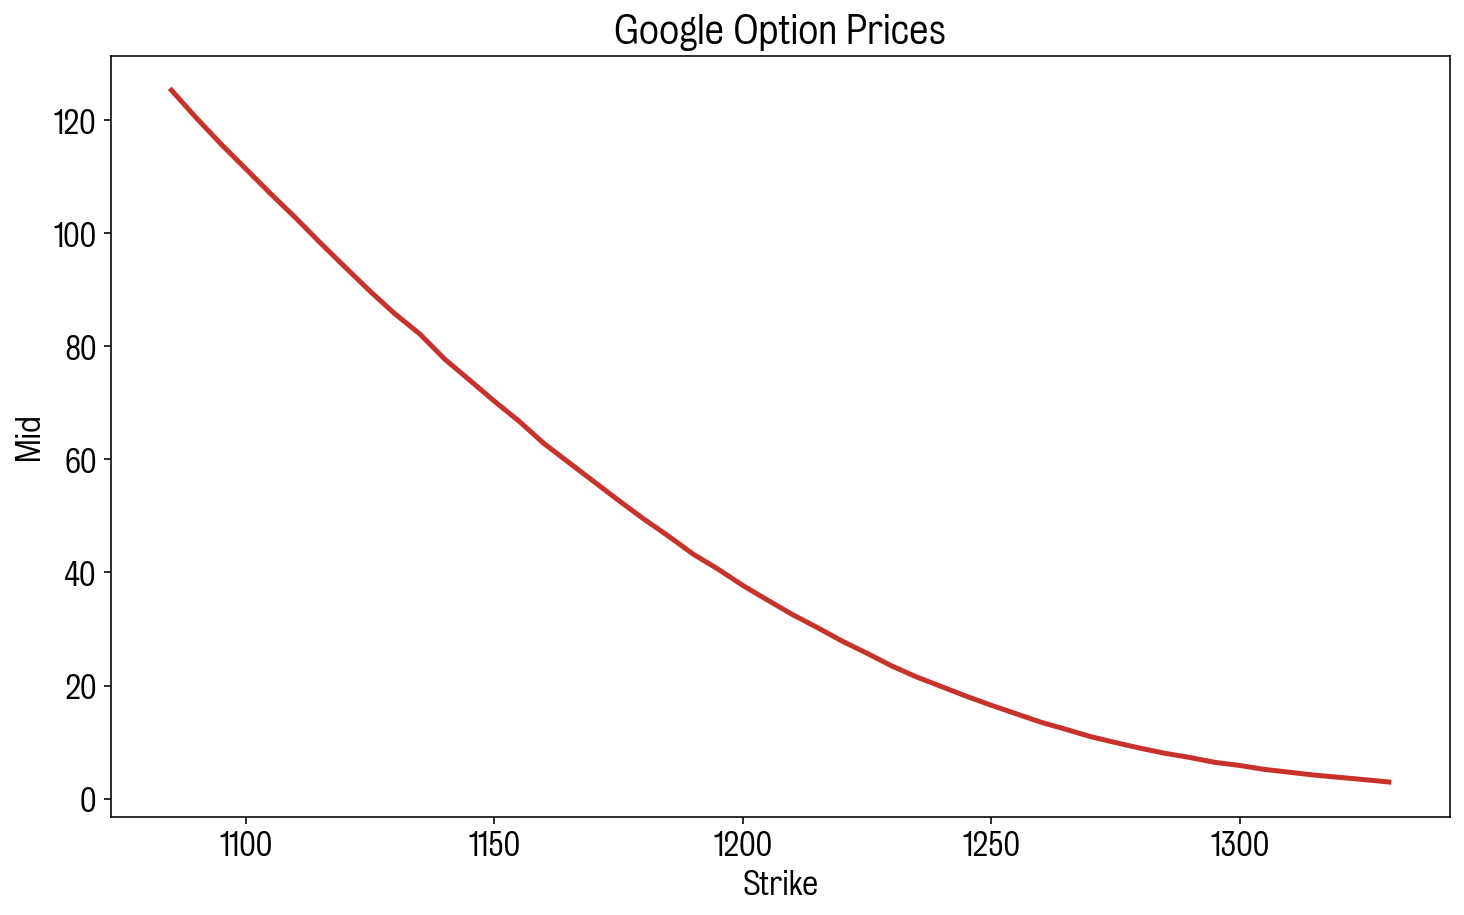

In [5]:
### BEGIN SOLUTION
import pandas as pd 

excel_data = pd.read_excel('goog-options.xlsx', header=None)
start_row = 4
num_rows = excel_data.shape[0]
num_options = num_rows-start_row
mid_prices = np.zeros(num_options)
strikes = np.zeros(num_options)
for i in range(0, num_options):
    mid_prices[i] = excel_data[2][start_row+i]
    strikes[i] = excel_data[3][start_row+i]
    
assert strikes[0]==1085, 'Check first row correct'
assert strikes[-1]==1330, 'Check last row correct'

sum_mids = sum( mid_prices )

ax = plt.gca()
ax.plot( strikes, mid_prices )
ax.set_xlabel('Strike')
ax.set_ylabel('Mid')
ax.set_title('Google Option Prices');
### END SOLUTION

In [6]:
check('7420b',sum_mids)
auto_marking_message()

Auto marking message: 😺 Correct


## Exercise

Suppose that short-selling is not allowed, so all the components of the weight vector must be positive. Write down a version of the optimization problem where short-selling is not allowed. Write a Python function that can solve this problem given a covariance matrix $\Sigma$ and mean vector $\mu$. This should work exactly like the `solve_markowitz` function in the handout except that it should be able to solve
the problem when short-selling is allowed and when short-selling is not allowed.

If short-selling is not allowed, then not all return values can actually be achieved, so sometimes your program will fail saying that the optimization is not feasible. However, I found that for the $\Sigma$ and $\mu$ used in the previous video that you can find solutions for expected returns in the range from 0 to 0.007.

If your code is correct, then the tests will plot a graph showing how the efficient frontier changes when short-selling is allowed
or not allowed.

In [7]:
# The next line stops the CVX optimiser filling your notebook with
# output: it produces a lot of annoying print out if you run it
# to solve the problem with short-selling prohibited.
cvxopt.solvers.options['show_progress'] = False

def solve_markowitz( sigma, mu, R, allow_short_selling = True ):
    ### BEGIN SOLUTION
    n = len( mu )
    
    P = 2*sigma
    q = np.zeros(n)
    A = np.array([np.ones(n),
         mu ])
    b = np.array([1,
         R]).T
    
    # Note that this section line is the key change from the code in the handouts
    if allow_short_selling:
        G = None
        h = None
    else:
        G = cvxopt.matrix(-np.identity(n))
        h = cvxopt.matrix(np.zeros(n))
    # End of key change
            
    res = cvxopt.solvers.qp(
        cvxopt.matrix(P),
        cvxopt.matrix(q), # q
        G,
        h,
        cvxopt.matrix(A),
        cvxopt.matrix(b))

    # Res is a map with keys, status, x and primal objective
    ret = {}
    assert res['status']=='optimal'

    w = res['x']
    var = res['primal objective']

    sd = sqrt(var)

    ret['weights']=w
    ret['sd']=sd

    return ret
    ### END SOLUTION

from markowitzlib import read_return_history as rrh
return_history = rrh()
mu = np.mean( return_history, axis = 0)
print(mu[0])

0.0023961073123495344


A mathematical formulation of the problem is
$$
\begin{array}{rcl}
\underset{{\bf w} \in {\mathbb R}^n}{\text{minimize}} & & {\bf w}^\top \Sigma {\bf w} \\
\text{subject to} & & {\bf 1}^\top {\bf w} = 1 \\
 & & {\boldsymbol{\mu}}^\top {\bf w} = R, \\
\text{and} & & -\boldsymbol{1}_n {\bf w} \leq \boldsymbol{0} 
\end{array}
$$
Where $\boldsymbol{1}_n$ is the $n \times n$ identity matrix.

[ 2.39610731e-03  3.27462735e-03  3.30773070e-03  3.21480212e-03
  7.61704849e-03  3.76547451e-03  4.66682332e-03  2.73376522e-03
  1.29734735e-03  1.56790525e-03  1.44145210e-03  4.56108192e-03
  2.51696623e-03  4.00031512e-03  3.28988332e-03  1.88867527e-03
  4.00084523e-03  2.81575689e-03  6.89177666e-04  2.88249252e-04
 -2.51482427e-05  1.19146841e-03  2.04161026e-03  2.06314856e-03
  2.25014616e-03  2.47188158e-03  6.07241074e-04  2.09387057e-03
  6.27391606e-04  2.66366719e-03  3.50839973e-03  3.36213961e-03
  2.70815669e-03  1.09120680e-03  1.30559779e-03  2.19521677e-03
  8.57929638e-04  3.03664618e-03  1.97546406e-03  1.32284392e-03
  1.11178076e-03  4.45129260e-03  1.52876360e-03  2.19214644e-03
  4.43317321e-03 -7.06958652e-05  3.52882743e-03  5.28694109e-04
  1.24001718e-03  1.27159802e-03  2.24321393e-03  3.65221687e-03
  3.39202590e-03  6.98244904e-03 -1.75223401e-04  3.10839038e-03
  9.43415190e-04  2.41514801e-03  3.34581269e-04  2.73798696e-03
  9.52473150e-04  2.91481

Auto marking message: 🌟 Correct


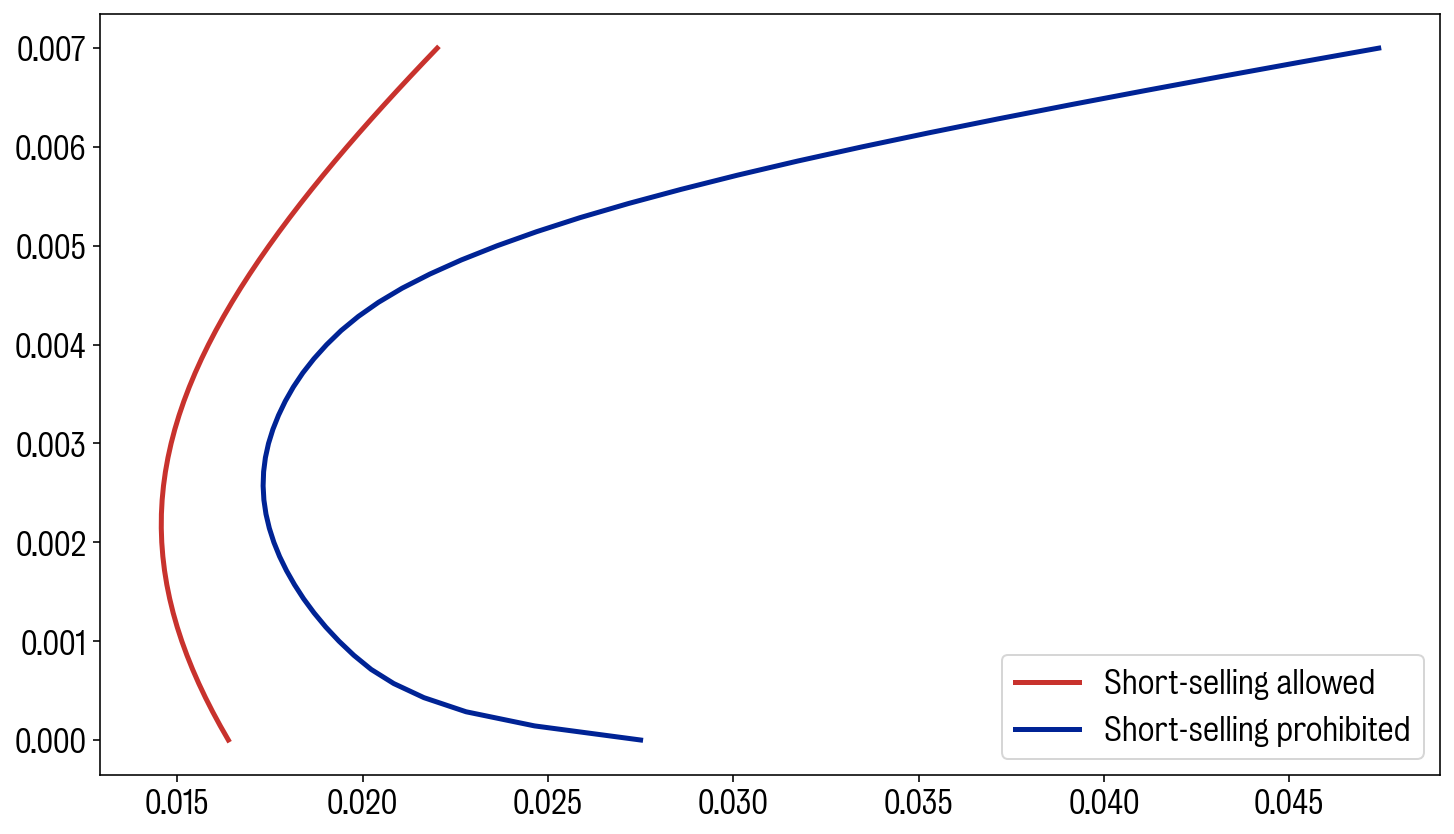

In [8]:
from markowitzlib import read_return_history as rrh
return_history = rrh()

mu = np.mean( return_history, axis=0 )
print(mu)
sigma = np.cov( return_history, rowvar=False )
res = solve_markowitz(sigma, mu, 0.003, True)
check( '1cf82d.1', res['sd'], tol=0.000001 )
res = solve_markowitz(sigma, mu, 0.003, False)
check( '1cf82d.2', res['sd'], tol =0.000001 )

for allow_short_selling in [True, False]:
    mu = np.mean( return_history, axis=0 )
    sigma = np.cov( return_history, rowvar=False )
    returns = np.linspace(0,0.007,50)
    min_sds = np.zeros(len(returns))
    for i in range(0,len(returns)):
        ret = solve_markowitz(sigma, mu, returns[i], allow_short_selling)
        min_sds[i] = ret['sd']

    ax = plt.gca()
    if allow_short_selling:
        l = 'Short-selling allowed'
    else:
        l = 'Short-selling prohibited'
    ax.plot(min_sds,returns, label=l);
    
ax.legend();
auto_marking_message()

## Exercise

Suppose that the market contains $n$ stocks. Suppose that the returns of the stocks over the time period $0$ to $T$ are given by independent identically distributed random variables
$R_1$, $R_2$, ..., $R_n$ each with mean $\mu$ and standard deviation $\sigma$. Find the weights of a portfolio whose return is $\mu$
and whose standard deviation is
$$\frac{1}{\sqrt{n}}\sigma.$$

Write a function `find_weights` which returns the weights of your portfolio.

**Hint:** What is the most diversified possible investment across these stocks?

In [9]:
def find_weights( n ):
    # BEGIN SOLUTION
    return np.ones(n)/n
    # END SOLUTION

In [10]:
n = 7
w = find_weights(n)
assert len(w)==7
check('cbd518.1', w.transpose() @ w)
check('cbd518.2', sum(w))
auto_marking_message()

Auto marking message: ✨ Correct


## Exercise

It isn't necessary to introduce the concept of returns to write down an optimization problem. In fact, it can be easier to work directly
with prices rather than returns. In this exercise, you should reformulate the Markowitz optimization problems without using returns.

Suppose that there are $n$ stocks in the market labelled $1$ up to $n$. 

The price of stock $i$ at time $0$ is $C_i$, so we may form a vector $\bf C$ whose components are given by the $C_i$.

The price of stock $i$ at time $T$ is a random variable $X_i$. We may form a random vector $\bf X$ with components $X_i$. We
assume that the expected value of ${\bm X}$ is the vector $\tilde{\boldsymbol{\mu}}$ and the covariance matrix of $\bf X$ is $\tilde{\Sigma}$.

We suppose that you buy $q_i$ units of stock $i$. So we may form a random vector $\bf q$ with components $q_i$. The stocks you hold at a given time are called your "portfolio". So the vector $\bf q$ determines your portfolio.

Derive vector formulae for:

* the total cost of the portfolio;
* the expected value of the portfolio at time $T$;
* and the variance of the portfolio at time $T$.

These can all be expressed in terms of  $\bf q$, $\bf C$, $\tilde{\boldsymbol{\mu}}$ and $\tilde{\Sigma}$.

Write down an optimization problem that expresses the idea that you wish to find the quantities $\bf q$ which minimize the
standard deviation of your portfolio subject to the requirement that it costs no more than $B$ to create the portfolio and the
expected payoff is at least $M$.

This is a mathematical question and is not automatically marked.

$$\begin{split}
\text{cost} &= \mathbf{C}^\top \mathbf{q} \\
\text{Expected value} &= \boldsymbol{\hat{\mu}}^\top \mathbf{q} \\
\text{Variance} &= \boldsymbol{q}^\top \boldsymbol{\hat{\Sigma}} \mathbf{q}
\end{split}$$

So the optimization problem may be written
$$
\begin{array}{rcl}
\underset{{\bf q} \in {\mathbb R}^n}{\text{minimize}} & & \sqrt{\boldsymbol{q}^\top \boldsymbol{\hat{\Sigma}} \mathbf{q}} \\
\text{subject to} & & \boldsymbol{\hat{\mu}}^\top \mathbf{q} \geq M \\
\text{and}  & & {\boldsymbol{C}}^\top {\bf q} \leq B
\end{array}
$$

